In [4]:
import os, joblib, json, numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import random

In [5]:
#load the saved preprocessed data

project_root = os.path.abspath(os.path.join(os.getcwd()))
processed_path = os.path.join(project_root, "Data", "Processed")

x_train = joblib.load(os.path.join(processed_path, "train_scaled.pkl"))
x_val = joblib.load(os.path.join(processed_path, "val_scaled.pkl"))
x_test = joblib.load(os.path.join(processed_path, "test_scaled.pkl"))
y_test = joblib.load(os.path.join(processed_path, "test_labels.pkl"))


x_train.shape, x_val.shape, x_test.shape

((1638568, 50), (409643, 50), (834347, 50))

In [6]:
# load scaler so that any new 
# traffic data (later) will be scaled 
# the exact same way as the trained data

scaler_path = os.path.join(processed_path, "scaler_cicids.pkl")

if os.path.exists(scaler_path):
    scaler = joblib.load(scaler_path)
else:
    scaler = None
    print("scaler not found")


In [7]:
# BUILD THE AUTOENCODER

# ensure same results every time
seed = 55
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)
os.environ['TF_DETERMINISTIC_OPS'] = '1'



input_dim = 50  # one input neuron for each feature

input_layer = Input(shape=(input_dim,), name="ae_input")   #entry point

# ENCODER (compression)
enc = Dense(32, activation='relu' , name="enc_dense_32")(input_layer)    
enc = Dense(16, activation='relu' , name="enc_dense_16")(enc)
bottleneck = Dense(8, activation='relu' , name="bottleneck_8")(enc)
# each layer takes the previous layer's output and transforms it to a smaller number of neurons
# ,this compresses the information
# ,the final layer is the compressed version the encoder learns to use for reconstructing the data


# DECODER (reconstruction)
dec = Dense(16, activation='relu' , name="dec_dense_16")(bottleneck)
dec = Dense(32, activation='relu', name="dec_dense_32")(dec)

# these layers start reconstructing the data back to the original 50 dimension
# basically the encoder extracts patterns, decoder just rebuilds

output_layer = Dense(input_dim, activation='linear', name="ae_output")(dec)


autoencoder = Model(inputs=input_layer, outputs=output_layer, name="Autoencoder")
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

autoencoder.summary()


Model: "Autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ ae_input (InputLayer)           │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_dense_32 (Dense)            │ (None, 32)             │         1,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_dense_16 (Dense)            │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bottleneck_8 (Dense)            │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_dense_16 (Dense)            │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_dense_32 (Dense)            │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ ae_output (Dense)               │ (None, 50)             │         1,650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,634 (18.10 KB)

 Trainable params: 4,634 (18.10 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# TRAIN THE AUTOENCODER

history = autoencoder.fit(
    x_train, x_train,       # input = output bec autoencoder tries to reconstruct
    epochs=50,              # number of times the model sees all data
    batch_size=256,
    validation_data=(x_val, x_val),  #check reconstruction on validation set (no attacks)
    # shuffle=False
)

Epoch 1/50
6401/6401 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - loss: 0.0535 - val_loss: 0.0253
Epoch 2/50
6401/6401 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 0.0229 - val_loss: 0.0214
Epoch 3/50
6401/6401 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.0201 - val_loss: 0.0192
Epoch 4/50
6401/6401 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.0183 - val_loss: 0.0177
Epoch 5/50
6401/6401 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.0170 - val_loss: 0.0165
Epoch 6/50
6401/6401 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - loss: 0.0160 - val_loss: 0.0158
Epoch 7/50
6401/6401 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 0.0153 - val_loss: 0.0152
Epoch 8/50
6401/6401 ━━━━━━━━━━━━━━━━━━━━ 30s 1ms/step - loss: 0.0146 - val_loss: 0.0146
Epoch 9/50
6401/6401 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.0141 - val_loss: 0.0142
Epoch 10/50
6401/6401 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 0.0138 - val_loss: 0.0139
Epoch 11/50
6401/6401 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 0.0135 - val_loss: 0.0137
Epoch 12/50
6401/64

In [9]:
# reconstruction error = how much the autoencoder failed to recreate the input

# get reconstructed outputs
train_pred = autoencoder.predict(x_train)
val_pred = autoencoder.predict(x_val)

# compute reconstruction error
train_mse = np.mean(np.square(x_train - train_pred), axis=1)
val_mse = np.mean(np.square(x_val - val_pred), axis=1)


51206/51206 ━━━━━━━━━━━━━━━━━━━━ 35s 688us/step
12802/12802 ━━━━━━━━━━━━━━━━━━━━ 10s 756us/step


In [10]:
# test on traffic with anomalies
# low error = normal behavior it understands
# high error = unusual behavior = anomaly

test_pred = autoencoder.predict(x_test)     # get reconstructed output of x+test

test_mse = np.mean(np.square(x_test - test_pred), axis=1)

train_mse[:10] , test_mse[:10]   #just to see examples

26074/26074 ━━━━━━━━━━━━━━━━━━━━ 21s 813us/step


(array([0.00063602, 0.01376794, 0.00389582, 0.00068052, 0.01823712,
        0.00612196, 0.00356715, 0.00131746, 0.05574058, 0.0011826 ]),
 array([0.00044858, 0.0014055 , 0.00037182, 0.00033878, 0.00554322,
        0.00037042, 0.00062363, 0.01876609, 0.00038864, 0.00630856]))

In [11]:
# set anomaly threshold 
# and decide which reconstruction errors indicate anomalies
# We want to decide which error value counts as an anomaly.


thresholds = np.linspace(min(test_mse), max(test_mse), 2000)  # finer granularity
best_f1 = 0
best_threshold = 0

for t in thresholds:
    y_pred_temp = (test_mse > t).astype(int)
    f1_temp = f1_score(y_test, y_pred_temp)
    if f1_temp > best_f1:
        best_f1 = f1_temp
        best_threshold = t

print("Best threshold:", best_threshold)
print("Best F1:", best_f1)




Best threshold: 0.01351718335317693
Best F1: 0.9078731441320762


In [12]:
y_pred = (test_mse > best_threshold).astype(int)
print("Number of anomalies detected:", np.sum(y_pred))
print("Actual number of anomalies:", np.sum(y_test))


Number of anomalies detected: 503972
Actual number of anomalies: 424704.0


In [13]:

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print("Accuracy: ", accuracy)
print("Precision: ", precision)     #how many of the detected anomalies were actually attacks
print("Recall: ", recall)           #how many actual attacks were caught
print("F1-score; ", f1)
print("Confusion matrix:\n", cm)

Accuracy:  0.8974575326572757
Precision:  0.8364750422642527
Recall:  0.9925971971066908
F1-score;  0.9078731441320762
Confusion matrix:
 [[327231  82412]
 [  3144 421560]]


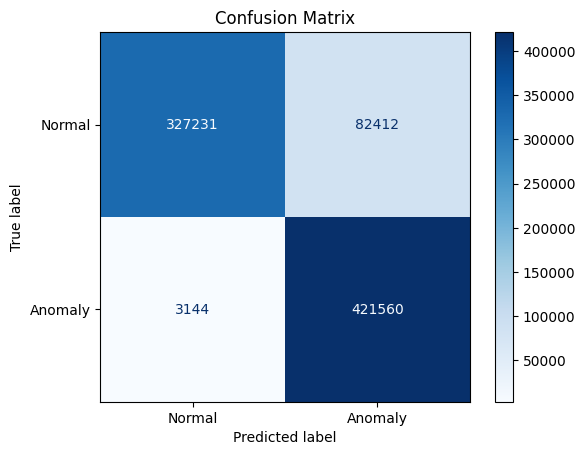

In [14]:
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Anomaly"])
disp.plot(cmap=plt.cm.Blues, values_format='d')  
plt.title("Confusion Matrix")
plt.show()


In [15]:
# import joblib
# import os

# project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
# models_path = os.path.join(project_root, "Models")
# os.makedirs(models_path, exist_ok=True)

# joblib.dump(autoencoder, os.path.join(models_path, "autoencoder.pkl"))
# joblib.dump(best_threshold, os.path.join(models_path, "ae_threshold.pkl"))


In [17]:
import numpy as np
import joblib
import os

# project_root = r"C:/Graduation Project/AI_Cybersecurity"
# models_path = os.path.join(project_root, "Models")
# os.makedirs(models_path, exist_ok=True)

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
models_path = os.path.join(project_root, "Models")
os.makedirs(models_path, exist_ok=True)

# ----------------------------------
# 1️ Predict (Reconstruction)
# ----------------------------------
X_test_recon = autoencoder.predict(x_test, verbose=0)  # تم تعديل الاسم هنا

# ----------------------------------
# 2️ Reconstruction Error (IMPORTANT)
# ----------------------------------
recon_error = np.mean(
    np.square(x_test - X_test_recon),  # تم تعديل الاسم هنا
    axis=1
)

# ----------------------------------
# 3️ Save NumPy artifacts ONLY
# ----------------------------------
joblib.dump(
    recon_error,
    os.path.join(models_path, "ae_preds.pkl")   # numbers only
)

joblib.dump(
    best_threshold,
    os.path.join(models_path, "ae_threshold.pkl")
)

# ----------------------------------
# 4️ Save model separately 
# ----------------------------------
autoencoder.save(
    os.path.join(models_path, "autoencoder.keras")
)


# Predict reconstructed outputs
# -------------------------------
train_pred = autoencoder.predict(x_train, verbose=0)
val_pred   = autoencoder.predict(x_val, verbose=0)

# -------------------------------
# Compute reconstruction error
# -------------------------------
train_mse = np.mean(np.square(x_train - train_pred), axis=1)
val_mse   = np.mean(np.square(x_val - val_pred), axis=1)

# -------------------------------
# Save reconstruction errors
# -------------------------------
joblib.dump(train_mse, os.path.join(models_path, "ae_train_scores.pkl"))
joblib.dump(val_mse, os.path.join(models_path, "ae_val_scores.pkl"))

['c:\\Graduation Project\\Models\\ae_val_scores.pkl']